<a name="Inicio"></a>
# Data Analysis

#### Autor: *Ángel Pérez Lemonche*


## Descripción general

Este script utiliza las matrices de transición generadas en "Learning Paths with General *bricks*" con el fin de analizar el contenido de los datos para tomar futuras decisiones. Se puede realizar el mismo proceso utilizando **vectores de frecuencias**, normalizando por el número total de transiciones por semanas.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0,'./lib/')
sys.path.append('./PIPElib/')


from PIPEAux import * 
from PIPEProcessing import *
from PIPETransitions import *
import myValFunctions as vf
import myClusteringFunctions as cf

In [ ]:
# Ficheros
folder = './Edicion1/'
dataFilename = folder+'eventos_final.json'
dictFilename = folder+'dateDictEd1.json'
assignationProblemCheckFile = folder+'IDNaturalProblemasEd1.csv'

In [ ]:
# Diccionario semana

from datetime import datetime

### EDICION 1 ##

sem1 = datetime(2015,2,24)
sem2 = datetime(2015,3,3)
sem3 = datetime(2015,3,10)
sem4 = datetime(2015,3,17)
sem5 = datetime(2015,3,24)
sem6 = datetime(2015,3,31)
sem7 = datetime(2015,4,7)
sem8 = datetime(2015,4,14)

# Diccionario solapado
OverLapedWeek = {"W1W2": [sem1, sem3],
       "W2W3": [sem2, sem4],
       "W3W4": [sem3, sem5],
       "W4W5": [sem4, sem6],
       "W5W6": [sem5, sem7]}

# Diccionario solapado
OverLapedWeek2 = {"W1W4": [sem1, sem5],
       "W2W5": [sem2, sem6],
       "W3W6": [sem3, sem7]}

# Diccionario de entrenamiento
dateDict = {'Course': [sem1, sem7]}

In [ ]:
# Entrenamiento de los clusters
eventsDF, eventsWeek = Preprocessing(dataFilename, minTotalUserEvents = 50, dateDict = dateDict, minWeeklyUserEvents = -1)

In [ ]:
# Transiciones x semana
dicEvents = {
    'V' : ['play_video', 'seek_video'],
    'N' : ['problem_check'],
    'F' : ['edx.forum.searched', 'edx.forum.comment.created', 
           'edx.forum.response.created', 'edx.forum.thread.created'],
    'P' : ['openassessmentblock.self_assess'],
    'D' : ['textbook.pdf.chapter.navigated']
}

param = {'dicEvents': dicEvents,
         'assignationProblemCheckFile': assignationProblemCheckFile,
         'ProblemCheckExceptions': ['J','X'],
         'pausaMin' : 0,
         'useFreq': True}

transitions = TransitionFeatures(eventsWeek, param)

In [ ]:
transitions = transitions['Course']
transitions.set_index('Usuario', inplace = True)
transitions.columns = [x[0:len(x)-7] for x in transitions.columns]

In [ ]:
# Selección de características

def MinMaxNorm(series):
    minim = series.min()
    maxim = series.max()
    return (series-minim)/(maxim-minim)

def ZNorm(series):
    mean = series.mean()
    std = series.std()
    return (series-mean)/std

def featFrequency(featuresDF, info = .95, Normalize = None, Use_Rest = True, verbose = 1):
    import pandas as pd
    featDF = featuresDF.copy()
    returnDF = featuresDF.copy()

    if Normalize != None:
        featDF = featDF.apply(lambda x: Normalize(x), axis=0)
    
    suma = featDF.sum(axis=0)
    perinfo = (abs(suma)/abs(suma).sum()).sort_values(ascending=False)
    cumsum = perinfo.cumsum()

    featInfo = pd.concat([perinfo, cumsum], axis = 1)
    featInfo.columns = ['percentage', 'cumsum']
    featInfo['selection'] = (featInfo['cumsum'] < info)

    returnDF = returnDF[featInfo.index[featInfo.selection]]

    if Use_Rest:
        returnDF['Rest'] = featuresDF[featInfo.index[featInfo.selection == False]].sum(axis=1)
    
    if verbose > 0:
        print('From',len(featuresDF.columns),'to',len(returnDF.columns), 'selected features.')
        if verbose == 2:
            pd.options.display.float_format = '{:,.2f}%'.format
            toPrint = featInfo[['percentage','cumsum']].apply(lambda x: x*100)
            toPrint['selection'] = featInfo.selection
            display(toPrint)
            pd.options.display.float_format = '{:,.4f}'.format
    
    return returnDF, list(featInfo.index[featInfo.selection])

In [ ]:
featuresDF, _ = featFrequency(transitions, info = .966, verbose = 2)

### Validación

In [ ]:
nClusters = 10
seed = 206
nRepetitions = 1000
computeClusterValidation = False


In [ ]:
if computeClusterValidation:
    av, st = vf.interClusterDistKMeans(featuresDF, nClusters = nClusters, nRandomStates = nRepetitions, 
                                    seed = seed, plot = True)

In [ ]:
if computeClusterValidation:
    av, st = vf.BICCriterionKMeans(featuresDF, nClusters = nClusters, nRandomStates = nRepetitions, 
                                    seed = seed, plot = True)

In [ ]:
if computeClusterValidation:
    av, st = vf.closestCentroidDistKMeans(featuresDF, nClusters = nClusters, nInit = nRepetitions, 
                                    seed = seed, plot = True)

In [ ]:
if computeClusterValidation:
    av, st = vf.silhouetteKMeans(featuresDF, nClusters = nClusters, nInit = nRepetitions, 
                                    seed = seed, plot = True)

In [ ]:
# EVALUATE THE PARAMETERS OF THE MODEL

from sklearn.cluster import KMeans
model = KMeans()

param_grid = {
    'n_clusters' : [6],
    'algorithm' : ['auto', 'full'],
    'init' : ['k-means++', 'random'],
    'n_init' : [20],
    'max_iter' : [200, 300],
    'random_state' : [None]
}

ParametersEvaluation = False

if ParametersEvaluation:
    nkFolds = 50
    scores, parameters, _ = vf.DeepCrossValidationClustering(featuresDF, 'KMeans', model, param_grid, kfold=nkFolds)

    print('\nEVALUATION\n')

    vf.evaluateResults(scores, parameters)

In [ ]:
nInitializations = 1000
nPartitions = 0
test_size = .20

model.set_params(n_clusters = 6, algorithm = 'auto', init = 'random', max_iter = 300, n_init = 50)

In [ ]:
model = model.set_params(n_clusters = 6)

model, bestSeed, results = vf.InitializationSeed(featuresDF, model, test_size = test_size, seed = seed,
                                nRandomStates = nInitializations)
print('Seed:', bestSeed)

In [ ]:
model = vf.CreatePartitionAndFitSelectedModel(featuresDF, model, test_size, bestSeed[0], bestSeed[1])
labels = model.predict(featuresDF)
centers = model.cluster_centers_

In [ ]:
cf.plotCentroids(centers, labels, featuresDF.columns, sort = [], avg = False, matrix = True, textThreshold = -.01)

In [ ]:
alpha = 10**-1

In [ ]:
DP, DC = vf.checkClusterPositions(featuresDF, model, test_size, results, alpha)
_ =[print("%d%%"%(x[0]*100),x[1],x[2],'\n') for x in DP if (x[0]*100)>2]

DC

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
cf.plotVectors(centers, dimensionNames = list(featuresDF.columns), colors = [], Nlevels = 10,
                logF = False, inv = True, minim = 0, verbose = True)

In [ ]:
import myfunclib as mf
import pandas as pd
import imp
mf = imp.reload(mf)
mf.showTable(pd.DataFrame(list(featuresDF.index), columns = ['users']), pd.DataFrame(labels, columns = ['labels']))

In [ ]:
MODIFICAR AQUI

In [ ]:
# Entrenamiento de los clusters
eventsDF, eventsWeek = Preprocessing(dataFilename, minTotalUserEvents = 50,
                                     dateDict = dateDict, minWeeklyUserEvents = 0)

In [ ]:
transWeek = {}
for week in eventsWeek:
    transWeek[week] = Transitions(eventsWeek[week], param)
    transWeek[week].set_index('Usuario', inplace = True)


In [ ]:
feat = featuresDF.columns[0:len(featuresDF.columns)-1]
transWeek2 = {}
for week in transWeek:
    transWeek2[week] = transWeek[week][transWeek[week].columns[transWeek[week].columns.isin(feat)]]
    notfeat = [not x for x in transWeek[week].columns.isin(feat)]
    notfeat = transWeek[week].columns[notfeat]
    transWeek2[week]['Resto'] = transWeek[week][notfeat].sum(axis = 1)
    
    transWeek2[week] = transWeek2[week].reindex_axis(featuresDF.columns, axis=1)

In [ ]:
LabelsPredict = {}
for week in transWeek2:
    df = pd.DataFrame([transWeek2[week].index, model.predict(transWeek2[week])], ['Usuario', 'Labels']).transpose()
    df = df.set_index('Usuario')
    LabelsPredict[week] = model.predict(transWeek2[week])

In [ ]:
np.unique(LabelsPredict['Course'])

In [29]:
weeks = list(enumerate(sorted(LabelsPredict)))
import numpy as np

M = np.matrix((np.unique(labels),np.unique(labels)))
transitMatrix = {}
for x in range(len(weeks)-1):
    M = np.zeros((len(np.unique(labels)),len(np.unique(labels)))).astype(int)
    for l in range(len(LabelsPredict[weeks[x][1]])):
        try:
            M[LabelsPredict[weeks[x][1]][l],LabelsPredict[weeks[x+1][1]][l]] += 1
        except:
            pass
    transitMatrix[weeks[x][1]+'->'+weeks[x+1][1]] = M.copy()

In [30]:
def transMatrix(df, possibleValues):
    '''
    Computes a cumulated transition matrix given a dataframe with two columns
        with numeric values (starting in 0) and a list with the possible number
        of values it can take.
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt

    # Initialization of the matrix
    M = np.zeros((len(possibleValues), len(possibleValues)))
    
    # for each row in the dataframe (entry or register)
    for row in range(len(df)):
        
        # Add 1 in the possition given by the first and the second row
        M[df[df.columns[0]][row]][df[df.columns[1]][row]] += 1
        
    # return with int type
    return M.astype(int)


In [31]:
import matplotlib.pyplot as plt

def plotTransMatrix(cm, classes, normalize = False, title = 'Transition Matrix', cmap = plt.cm.Greys, Sum = True, perc = True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize = True'.
    """
    
    import numpy as np
    import itertools
    import matplotlib.pyplot as plt
    perc = (perc and normalize)*99 + 1
    
    # If normalize flag is true, we normalize in the 0 axis
    if normalize:
        cm.astype('float')
        cm = (cm.T / cm.sum(axis=1)).T
        #cm = cm.astype('float') / sum(cm.sum(axis=1)[:, np.newaxis])

        # having done that, we may obtain 0/0 inconsistences. 
        # we define 0/0 as 0
        cm = np.nan_to_num(cm)
        title = 'Normalized '+title

    # Add sum of the answers
    if Sum:
        # Initialization of the matrix
        black = False


        if black:
            c = cm.max()
        else:
            c = 0
        row = c*np.ones(np.shape(cm)[1])
        cm2 = np.vstack((cm, row))
        cm3 = np.transpose(cm2)
        row = c*np.ones(np.shape(cm3)[1])
        cm4 = np.vstack((cm3, row))
        cm = np.transpose(cm4)
        

    # Plot the confusion matrix
    plt.imshow(cm*perc, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Set the ticks for both axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Format of the printing 
    #fmt = '.2f' if normalize else 'd'
    fmt = '.0f'


    
    # Threshold to change the color
    thresh = cm.max() / 2.
    
    # Set the text over each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                      
        # Print the sum of all rows and columns
        if i == len(classes) and j == len(classes) and Sum:
            text = ' '
            #text = (format(cm.sum()*perc, fmt))
            fw = 'normal'
        elif j == len(classes) and Sum:
            text = format(cm[i,0:len(classes)].sum()*perc, fmt)
            fw ='bold'
        elif i == len(classes) and Sum:
            text = format(cm[0:len(classes),j].sum()*perc, fmt)
            fw ='bold'
        else:
            text = format(cm[i, j]*perc, fmt)
            fw = 'normal'
            
            
        plt.text(j, i, text, horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontweight=fw)

    # Set tight layout and x and y labels
    plt.tight_layout()
    
    auxLab = title.split('->')
    auxLab2 = auxLab[0].split(" ")
    plt.ylabel(auxLab2[len(auxLab2)-1])
    plt.xlabel(auxLab[1])


/home/angelpl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


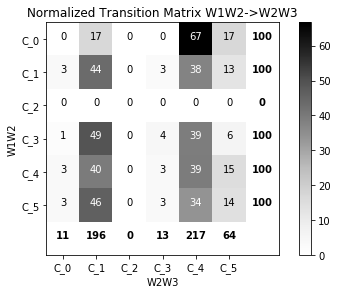

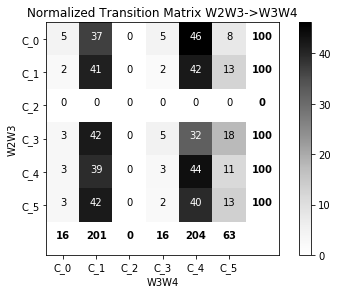

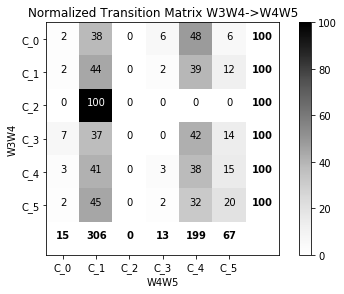

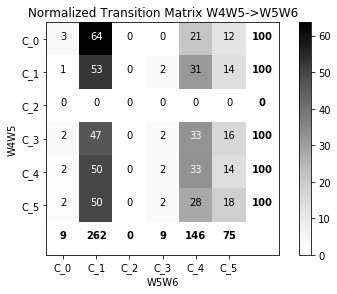

In [32]:
for key in transitMatrix:
    plt.figure()
    plotTransMatrix(transitMatrix[key], ['C_'+str(x) for x in np.unique(labels)] , 
                normalize = True, title = 'Transition Matrix '+key, cmap = plt.cm.Greys, Sum = True, perc = True)


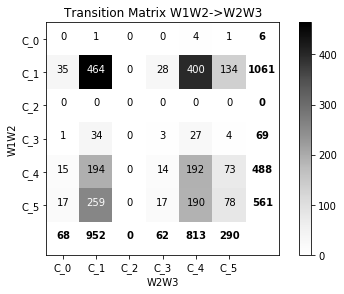

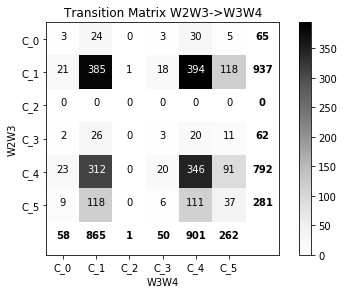

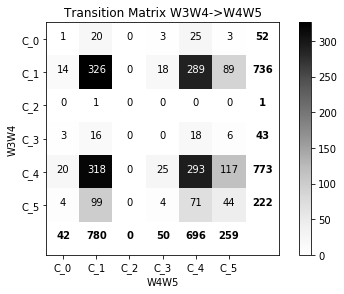

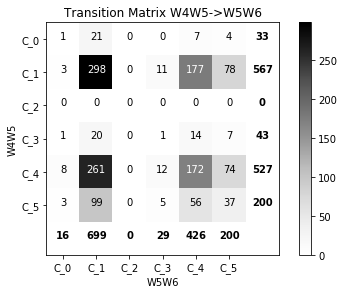

In [33]:
for key in transitMatrix:
    plt.figure()
    plotTransMatrix(transitMatrix[key], ['C_'+str(x) for x in np.unique(labels)] , 
                normalize = False, title = 'Transition Matrix '+key, cmap = plt.cm.Greys, Sum = True, perc = True)

In [34]:
# Centroides Cluster D2D
D2DCluster = featuresDF[:][labels == 2].mean()
D2DCluster = D2DCluster.rename(index={'Rest': 'Resto'})

for week in LabelsPredict:
    # Posicion de los estudiantes D2D por semana
    position_students_D2D_sem = transWeek2[week][labels == 2]

    # N students
    total = len(position_students_D2D_sem)
    
    # Distancia euclidea en cada dimensión
    dist_cluster = (abs(position_students_D2D_sem-D2DCluster)**2).sum()
    
    print(total,'Students, Distance D2D, Week:',week, ":", "%.2f"%(dist_cluster.sum()))
    print(dist_cluster)
    
    avgPos = position_students_D2D_sem.mean()
    print("Centroid")
    print(D2DCluster)
    print("Avg Pos")
    print(avgPos)
    print()

    assigned_clusters = LabelsPredict[week][labels == 2]
    for ac in np.unique(assigned_clusters):
        
        # Estudiantes del cluster D-D que estan asignados esa semana en otro cluster (etiqueta ac)
        students = np.logical_and((labels == 2), (LabelsPredict[week] == ac))
        
        # Posicion de los estudiantes D2D en otro cluster ac
        position_students_Other_sem = transWeek2[week][(students)]
        
        # Centroide del otro cluster
        OtherCluster = featuresDF[:][labels == ac].mean()
        OtherCluster = OtherCluster.rename(index={'Rest': 'Resto'})
        
        # N estudiantes del cluster general D2D en otro cluster ac
        nstudents = len(position_students_Other_sem)
        
        # Distancia euclidea en cada dimension
        dist_cluster = (abs(position_students_Other_sem-OtherCluster)**2).sum()

        print("%.2f"%(nstudents/total*100),'% of D->D Students, Distance Cluster',ac,', Week:', week, ":",
              "%.2f"%(dist_cluster.sum()))
        
        print(dist_cluster)
        
        avgPos = position_students_Other_sem.mean()
        print("Centroid")
        print(OtherCluster)
        print("Avg Pos")
        print(avgPos)
        print()



ValueError: Item wrong length 3138 instead of 2483.

In [ ]:
(abs(position_students_D2D_sem-D2DCluster)**2).sum()